In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import numpy as np

import scipy.io
import scipy.signal 

from matplotlib import mlab
import matplotlib.pyplot as plt


In [3]:
def psd(trials):
    
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 101, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs


def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

def bandpass(trials, lo, hi, sample_rate):
 
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

def logvar(trials):
    return np.var(trials, axis=1)

def plot_logvar(trials, trial_no = None):
    plt.figure(figsize=(12,5))

    print(trials[cl1].shape)
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    if trial_no == None:
        y0 = np.mean(trials[cl1], axis=1)
        y1 = np.mean(trials[cl2], axis=1)
    else:
        y0 = trials[cl1][:,trial_no]
        y1 = trials[cl2][:,trial_no]

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

from numpy import linalg

def cov(trials):
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_r, trials_f):
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

import torch
import snntorch.spikeplot as splt
from snntorch import spikegen

def spike_latency(trials, trial_n, cls, num_steps):
    input_data = trials[cl1] if cls == 1 else trials[cl2]
    
    tensor = torch.tensor(input_data[:,trial_n])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    
    spike_data = spikegen.latency(tensor, num_steps=num_steps, threshold=(np.mean(input_data[:,trial_n])+1)*1/2, bypass=True)

    return spike_data

def spike_rate(trials, trial_n, cls, num_steps):
    input_data = trials[cl1] if cls == 1 else trials[cl2]
    
    tensor = torch.tensor(input_data[:,trial_n])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    
    spike_data = spikegen.rate(tensor, num_steps=num_steps)

    return spike_data

def plot_raster(spike_data):
    
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    ax = fig.add_subplot(111)
    
    spike_data_sample = spike_data
    splt.raster(spike_data_sample, ax, s=1.5, c="black")
    plt.ylim(0, 60)
    
    plt.title("Input Layer")
    plt.xlabel("Time step")
    plt.ylabel("Neuron Number")
    plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.1, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.1, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_yticks([0, 1], ['left', 'right'])
  ax[2].set_ylim([-0.5, 1.5])


  plt.show()

def plot_snn_spikes_modified(spk_in, spk1_rec, spk2_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=False, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes

  neuron_numbers = list(range(59))
  currents = spk_in.tolist()  # Currents fed to each neuron
    
  # Create bar chart
  ax[0].bar(neuron_numbers, currents, color='skyblue')
  ax[0].set_ylabel("Input Currents")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_yticks([0, 1], ['left', 'right'])
  ax[2].set_ylim([-0.5, 1.5])


  plt.show()

In [4]:
m = scipy.io.loadmat('BCICIV_1_mat\BCICIV_calib_ds1d.mat', struct_as_record=True)

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

In [5]:
trials = {}

win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

nsamples = len(win)

for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    cl_onsets = event_onsets[event_codes == code]

    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

In [6]:
trials_filt = {cl1: bandpass(trials[cl1], 2, 30, sample_rate),
               cl2: bandpass(trials[cl2], 2, 30, sample_rate)}

In [7]:
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}

In [8]:
trials_logvar = {cl1: logvar(trials_csp[cl1]),
                 cl2: logvar(trials_csp[cl2])}

In [9]:
normalized_within_trial = {cl1: ((trials_logvar[cl1]-np.min(trials_logvar[cl1],axis=0))/(np.max(trials_logvar[cl1],axis=0)-np.min(trials_logvar[cl1],axis=0))),
                 cl2: ((trials_logvar[cl2]-np.min(trials_logvar[cl2],axis=0))/(np.max(trials_logvar[cl2],axis=0)-np.min(trials_logvar[cl2],axis=0)))}

In [10]:
max_value = np.max(trials_logvar[cl1]) or np.max(trials_logvar[cl2])
min_value = np.min(trials_logvar[cl1]) or np.min(trials_logvar[cl2])


normalized_trials_logvar = {cl1: ((trials_logvar[cl1]-min_value)/(max_value-min_value)),
                 cl2: ((trials_logvar[cl2]-min_value)/(max_value-min_value))}

In [11]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        if len(self.data.shape) > 1:
            return self.data.shape[1]
        else:
            return 1

    def __getitem__(self, idx):
        sample = self.data[1:,idx]
        label = self.data[0,idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [13]:
data = normalized_within_trial

# Additional column for class identifiers
class_column_left = np.zeros((1, 100))  # Assuming all instances belong to class 0
class_column_right = np.ones((1, 100))  # Assuming all instances belong to class 0

# Concatenate class column along with left and right arrays
left_with_class = np.concatenate([class_column_left, data['left']], axis=0)
right_with_class = np.concatenate([class_column_right, data['right']], axis=0)

# Concatenate left and right arrays along axis 1
result = np.concatenate([left_with_class, right_with_class], axis=1)

cl1_split_idx = int(result.shape[1]*0.5*0.8)
cl2_split_idx = int(result.shape[1]*0.5*1.8)

train_data = np.concatenate([result[:, :cl1_split_idx],result[:, 100:cl2_split_idx]], axis=1)
test_data = np.concatenate([result[:, cl1_split_idx:100],result[:, cl2_split_idx:]], axis=1)

# Create CustomDataset instance
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for samples, labels in train_loader:
    # Your training code here
    print(samples.shape, labels.shape)

torch.Size([32, 59]) torch.Size([32])
torch.Size([32, 59]) torch.Size([32])
torch.Size([32, 59]) torch.Size([32])
torch.Size([32, 59]) torch.Size([32])
torch.Size([32, 59]) torch.Size([32])


C:\Users\USER\AppData\Local\Temp\ipykernel_6436\1880285545.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [14]:
test_data.shape

(60, 40)

In [15]:
num_inputs = 59
num_hidden = 1000
num_outputs = 100
beta = 0.99

In [35]:
# Define Network
class Net(nn.Module):
    def __init__(self, num_steps):
        super().__init__()

        self.num_steps = num_steps

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

        self.spkIn = []
        self.spk1 = []
        self.spk2 = []

    def _rate_coding(self, x):
        tensor = torch.tensor(x)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        tensor = tensor.to(device)
    
        spike_data = spikegen.rate(tensor, num_steps=self.num_steps)

        return spike_data

    def test(self,x):
        print(x.shape)
        print(self._rate_coding(x).shape)
        
        
    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        self.spkIn = []
        self.spk1 = []
        self.spk2 = []
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        spk_in = self._rate_coding(x)

        for step in range(self.num_steps):
            cur1 = self.fc1(spk_in[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            print(spk1.shape)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            self.spkIn.append(spk_in[step])
            self.spk1.append(spk1)
            self.spk2.append(spk2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        print(len(mem2_rec))
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net(100).to(device)

In [36]:
for samples, labels in train_loader:
    net.forward(samples)

C:\Users\USER\AppData\Local\Temp\ipykernel_6436\1880285545.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_6436\1143056328.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size(

In [37]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [38]:
#loss = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [34]:
import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.ce_count_loss(population_code=True, num_classes=2)

In [43]:
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
num_steps = 100

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss_fn(spk_rec, targets)
        #for step in range(num_steps):
            #loss_val += loss_fn(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = loss_fn(test_spk, test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 1 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

C:\Users\USER\AppData\Local\Temp\ipykernel_6436\1880285545.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_6436\1143056328.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size(

In [21]:
loss_val = torch.zeros((1), dtype=dtype, device=device)

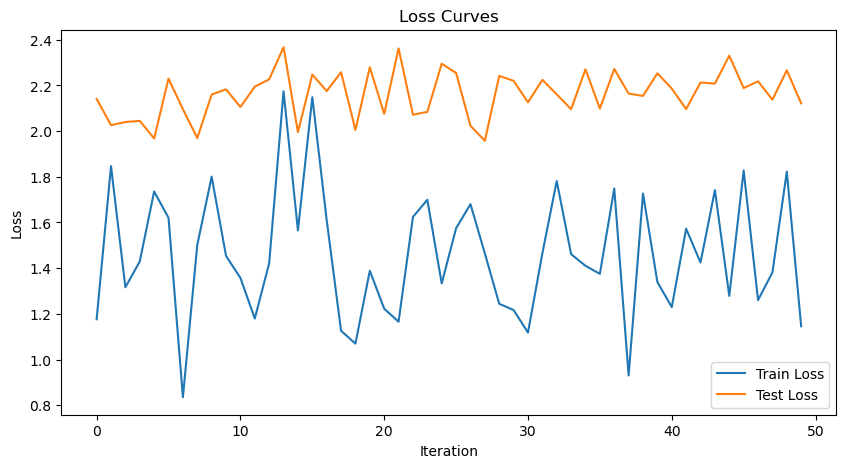

In [44]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

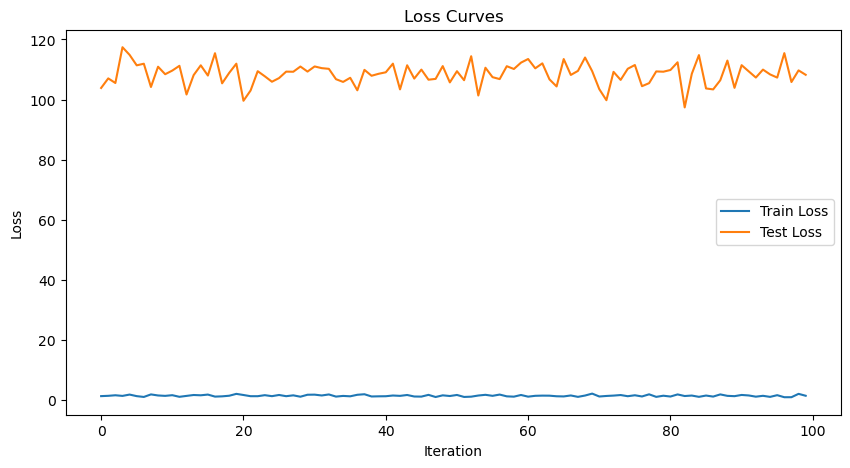

In [42]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

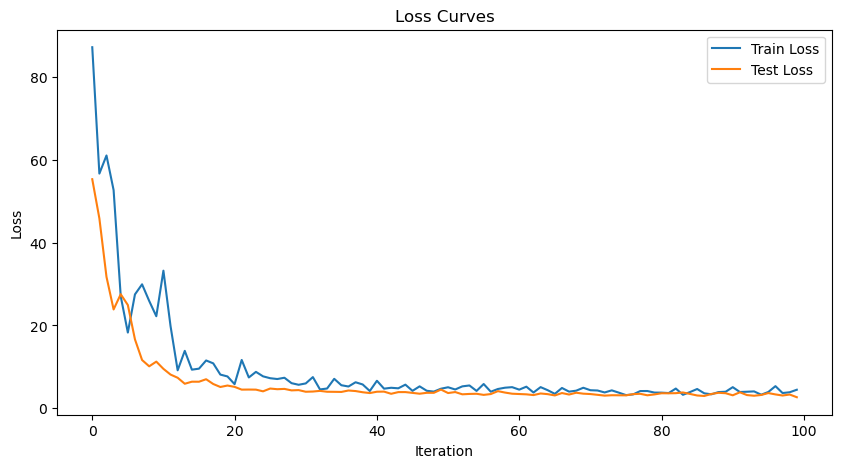

In [24]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_6436\1880285545.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_6436\1143056328.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([

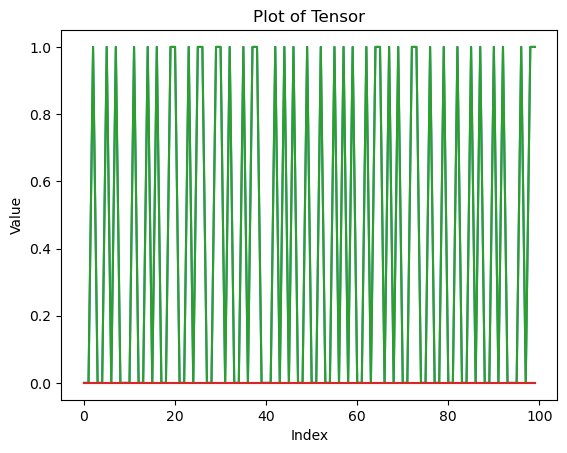

torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([

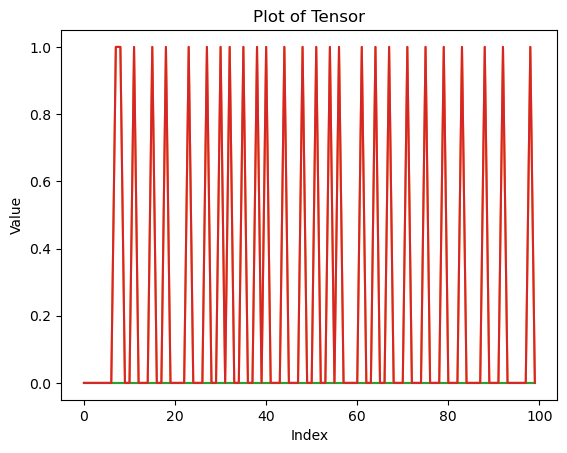

In [25]:
for samples, labels in test_loader:
    

    output = net(samples[3])
    print()
    print(labels[3])

    tensor_output = output[0]  # Extract the tensor from the tuple
    numpy_array = tensor_output.detach().numpy()  # Convert tensor to numpy array
    plt.plot(numpy_array)
    # Plot the numpy array
    plt.plot(numpy_array)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Plot of Tensor')
    plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_6436\1880285545.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_6436\1143056328.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


torch.Size([59])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([10

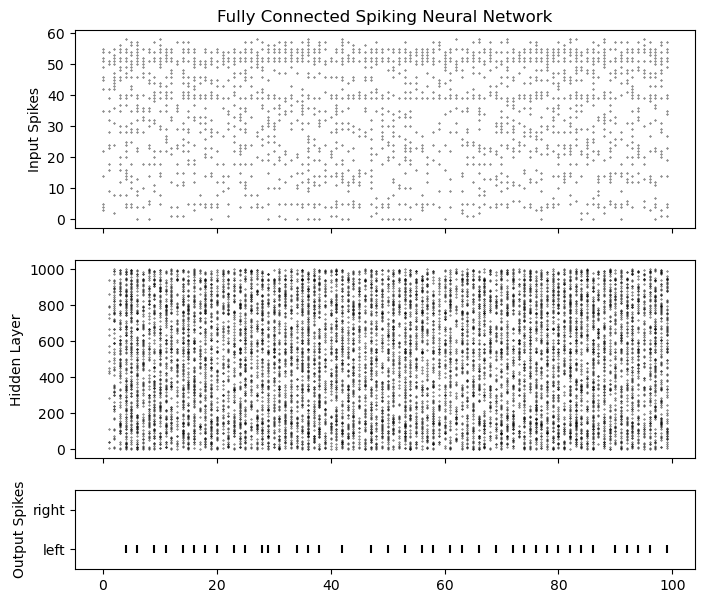

torch.Size([59])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([10

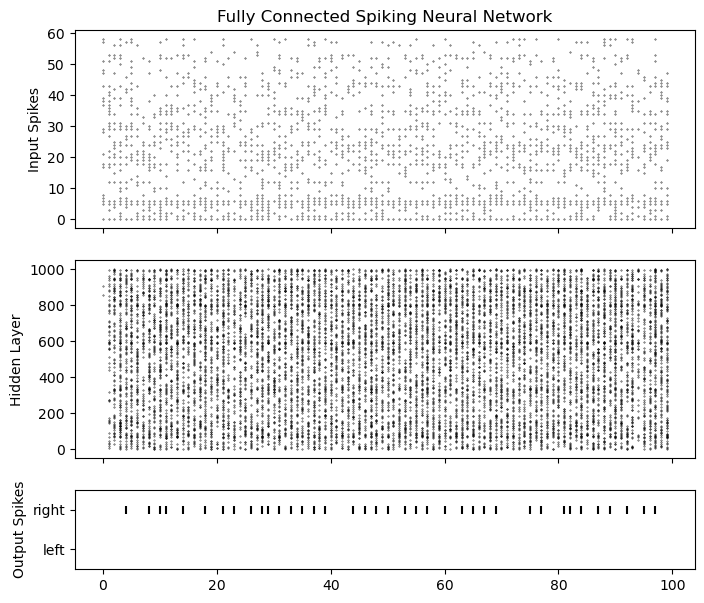

In [26]:
for samples, labels in test_loader:
    print(samples[2].shape)
    output = net(samples[2])
    
    spk_In = torch.stack(net.spkIn).unsqueeze(1)
    spk_rec1 = torch.stack(net.spk1)
    spk_rec2 = torch.stack(net.spk2)
    print(spk_In.shape)
    plot_snn_spikes(spk_In, spk_rec1, spk_rec2, num_steps, "Fully Connected Spiking Neural Network")

In [27]:
torch.save(net.state_dict(), 'model.pth')

In [28]:
print(spk_rec1.shape)

torch.Size([100, 1000])
